In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sentence_transformers import SentenceTransformer
import torch
import os

#model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
sent_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
image_save_path = os.path.join(os.getcwd(), 'plots', 'intial-plots')

/home/llm-hackathon/enter/envs/datalite_env/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [27]:
image_save_path

'/home/llm-hackathon/LLaVA/luke_scratch/plots/intial-plots'

### Impressions Formatting and EDA
* impressions df: hackathon fine tune on full dataset through 2020
* running inference on data that the model was fine tuned on. 
* Semi useful analysis, I guess.

In [3]:
def break_convos(df, col1, col2):
    '''takes in conversations column and breaks it up into separate columns for data frame'''
    ser = df['conversations']
    prompt = pd.json_normalize(ser.apply(lambda x: x[0]))['value']
    impressions = pd.json_normalize(ser.apply(lambda x: x[1]))['value']

    df[col1] = prompt
    df[col2] = impressions

    df = df.drop(axis=1, columns=['conversations'])

    return df

In [4]:
def read_image(image_path):
    # Read the image
    img = mpimg.imread(image_path)

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

In [5]:
def select_random_img():
    idx = np.random.randint(merged_df.shape[0])
    row = merged_df.iloc[idx]

    read_image(row['image'])
    print(f"id: {row['id']}\nradiologist report: {row['radiologist_report']}\nllava_prompt: {row['llava_prompt']}\nimpression: {row['llava_impression']}")

## Train-Test Split Dataset Inference Analysis 
Loads in Datasets:

1. `test_inference`: loads in the test data from llava fine tune. focus of analysis. has most information needed.
3. `train_df`: contains the information that the llava model was fine tuned on (prompt, author, clinical history, question, findings, impression from radiologist)
2. `test_questions`: not important, test_inference will have all the same data
3. `csv_t2020_df`: original reports data set, has double the amount of the train test split data because of image accessibility issues. Can be used for more text analysis, if needed. 

In [6]:
# this cell loads in and formats data frames to facilitate analysis
test_questions_path = '../../LLaVA-old/data/01-29-24/test_questions_finding_impression.jsonl' 
test_inference_path = '../../LLaVA-old/data/01-29-24/test_inference.jsonl'
train_data_path = '../raymond/022624patient_finding_impression.json'

test_questions = pd.read_json(test_questions_path, lines=True)
test_inference = pd.read_json(test_inference_path, lines=True)
train_df = pd.read_json(train_data_path).drop(axis=1, columns='image')
train_df = break_convos(train_df, 'prompt', 'radiologist_report')
csv_t2020_df = pd.read_csv('/home/llm-hackathon/Downloads/fixed-data-csv/all-reports-available-xrays-through2020-final.csv').drop(axis=1, columns='Unnamed: 0')


test_inference[['phonetic_id', 'id']] = test_inference['question_id'].str.split('_', expand=True)
test_questions[['phonetic_id', 'id']] = test_questions['question_id'].str.split('_', expand=True)
train_df[['phonetic_id', 'id']] = train_df['id'].str.split('_', expand=True)

test_inference['id'] = test_inference['id'].astype(int)
train_df['id'] = train_df['id'].astype(int)

test_inference.rename(columns={'text': 'llava_report'}, inplace=True)
test_questions.rename(columns={'text': 'prompt'}, inplace=True)

test_inference = test_inference[['id', 'phonetic_id', 'prompt', 'llava_report']]
test_questions = test_questions[['id', 'phonetic_id', 'prompt']]

# split information into separate columns for readability
# train df 
train_df['author'] = train_df['prompt'].str.split('\n', expand=True)[0].str.split('AUTHOR: ', expand=True)[1].str.strip()
train_df['clinical_history'] = train_df['prompt'].str.split('CLINICAL HISTORY:', expand=True)[1].str.split('\nBased on AUTHOR and', expand=True)[0].str.strip()
train_df[['findings', 'impression']] = train_df['radiologist_report'].str.split('IMPRESSION:', expand=True)[[0, 1]]
train_df['findings'] = train_df['findings'].str.split('FINDINGS:', expand=True)[1].str.strip()
x
# test inference
test_inference['author'] = test_inference['prompt'].str.split('\n', expand=True)[0].str.split('AUTHOR: ', expand=True)[1].str.strip()
test_inference['clinical_history'] = test_inference['prompt'].str.split('CLINICAL HISTORY:', expand=True)[1].str.split('\nBased on AUTHOR and', expand=True)[0].str.strip()
test_inference[['findings', 'impression']] = test_inference['llava_report'].str.split('IMPRESSION:', expand=True)[[0, 1]]
test_inference['findings'] = test_inference['findings'].str.split('FINDINGS:', expand=True)[1].str.strip()

# test questions has no new information (besides the question asked), which hasn't been changed all that much, so 
# we won't focus on this data frame for now
# print question asked
print('Test Set Prompt:')
print(test_questions['prompt'].str.split('\n', expand=True)[2].unique()[0])

train_df = train_df[['id', 'phonetic_id', 'author', 'clinical_history', 'findings', 'impression']]
test_inference = test_inference[['id', 'phonetic_id', 'author', 'clinical_history', 'findings', 'impression', 'llava_report']]

train_df.rename(columns={'findings': 'radiologist_findings', 'impression': 'radiologist_impression'}, inplace=True)
test_inference.rename(columns={'findings': 'llava_findings', 'impression': 'llava_impression'}, inplace=True)

# 'DocumentTitle', 'DocumentDate' are columns we can use from csv_t2020_df
test_inference = test_inference.merge(csv_t2020_df[['AccessionId', 'answer']], left_on='id', right_on='AccessionId').drop(axis=1, columns='AccessionId') 
test_inference[['radiologist_findings', 'radiologist_impression']] = test_inference['answer'].str.split('IMPRESSION:', expand=True)[[0, 1]]
test_inference['radiologist_findings'] = test_inference['radiologist_findings'].str.split('FINDINGS:', expand=True)[1].str.strip()
test_inference.rename(columns={'answer': 'radiologist_report'}, inplace=True)#test_inference.drop(axis=1, columns='answer', inplace=True)

# replace None rows so we don't get an error
test_inference['radiologist_impression'] = test_inference['radiologist_impression'].fillna(' ')
test_inference['llava_impression'] = test_inference['llava_impression'].fillna(' ')

string_cols = [
 'phonetic_id',
 'author',
 'clinical_history',
 'llava_findings',
 'llava_impression',
 'llava_report',
 'radiologist_report',
 'radiologist_findings',
 'radiologist_impression']

for col in string_cols:
    test_inference[col] = test_inference[col].str.strip()

#clean up csvt_2020_df in similar manner
# or maybe just make a function that takes in columns, splits and cleans? 
# TODO ^!

/tmp/ipykernel_1014521/1823698469.py:6: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  test_questions = pd.read_json(test_questions_path, lines=True)


ValueError: Expected object or value

In [6]:
test_inference.head()

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.


In [7]:
list(test_inference.columns)

['id',
 'phonetic_id',
 'author',
 'clinical_history',
 'llava_findings',
 'llava_impression',
 'llava_report',
 'radiologist_report',
 'radiologist_findings',
 'radiologist_impression']

In [8]:
def get_sim_scores(col1, col2):
    '''takes in two columns which each row in each column a sentence that corresponds with each other. 
    returns a similarity score series the same length as inputs'''
    
    embeddings1 = sent_model.encode(col1)
    embeddings2 = sent_model.encode(col2)
    
    return embeddings1, embeddings2, np.diag(embeddings1 @ embeddings2.T)

llava_embeddings, radiologist_embeddings, test_inference['similarity'] = get_sim_scores(test_inference['llava_report'], test_inference['radiologist_report'])

test_inference.head()

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.,0.765192
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...,0.886013
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.,0.849271
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...,0.883281
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.,0.904612


In [9]:
def sample_by_bin(df, col, bin_index):
    '''
    col -- name of column to get similarities from
    bin_index -- a number from 1 to 11 (probably)'''
    sim_scores = df[col]
    bin_indices = np.digitize(sim_scores, bins=np.histogram_bin_edges(sim_scores))
    bools = bin_indices == bin_index
    filtered = sim_scores[bools]
    df_subset = df[bools]
    
    i = np.random.randint(0, high=len(filtered))
    return df_subset.iloc[i]

In [10]:
def print_row_nicely(row):
    """
    This function takes a row of data (as a dictionary) and prints it out in a formatted manner.
    
    Parameters:
    row (dict): A dictionary representing a row of data, where keys are column names.
    """
    read_image('/data/UCSD_cxr/jpg/' + row['phonetic_id'] + '_' + str(row['id']) + '.jpg')
    print("Row Data Overview:")
    print("-" * 50)  # Print a divider for better readability
    for key, value in row.items():
        if key == 'llava_report':
            pass
        elif key =='radiologist_report':
            pass
        # Formatting each key-value pair nicely
        else:
            print(f"{key}:".ljust(25) + f"{value}")
    print("-" * 50)  # End with a divider for a clean look

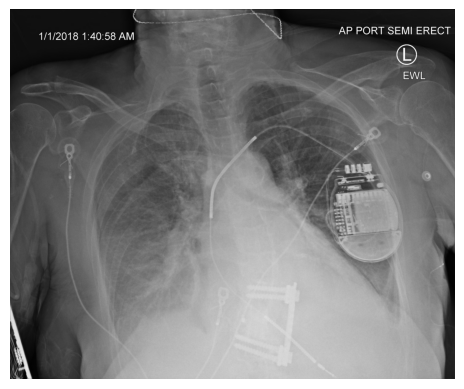

Row Data Overview:
--------------------------------------------------
id:                      50209558
phonetic_id:             Femostey
author:                  Hsiao, Albert
clinical_history:        Heart failure reduced ejection fraction
llava_findings:          See impression.
llava_impression:        Interval removal of the right upper extremity PICC line.
radiologist_findings:    A single lead ICD is present over the left chest. The cardiomediastinal silhouette is enlarged. Interstitial and alveolar pulmonary edema are present. There are bilateral pleural effusions, right greater than left with associated bibasal airspace opacities. Thoracolumbar fusion hardware is present. Visualized osseous structures otherwise appear grossly intact. Calcified descending thoracic aorta noted..
radiologist_impression:  Cardiomegaly with interstitial and alveolar pulmonary edema and bilateral pleural effusions.
Dense bibasal airspace opacities, which may represent atelectasis or consolidation. P

In [11]:
sampled_row = sample_by_bin(test_inference[test_inference['author'] == 'Hsiao, Albert'], 'similarity', 1)
print_row_nicely(sampled_row)

In [12]:
see_impression_bools = test_inference['llava_findings'].str.lower().str.contains('see impression') | test_inference['llava_findings'].str.lower().str.contains('unknown') | (test_inference['llava_findings'] == '')
see_impression = test_inference['llava_findings'].str.lower()[see_impression_bools]
see_impression_lens = see_impression[see_impression_bools].str.len()

test_inference['is_si_l'] = see_impression_bools 
test_inference['is_si_r'] = test_inference['radiologist_findings'].str.lower().str.contains('see impression') | test_inference['radiologist_findings'].str.lower().str.contains('unknown') | (test_inference['radiologist_findings'] == '')

In [13]:
llava_impression_lengths = test_inference['llava_impression'].str.len()
llava_findings_lengths = test_inference['llava_findings'].str.len()
radiologist_impression_lengths = test_inference['radiologist_impression'].str.len()
radiologist_findings_lengths = test_inference['radiologist_findings'].str.len()

test_inference['lf_len'] = llava_findings_lengths
test_inference['li_len'] = llava_impression_lengths
test_inference['rf_len'] =radiologist_findings_lengths
test_inference['ri_len'] = radiologist_impression_lengths

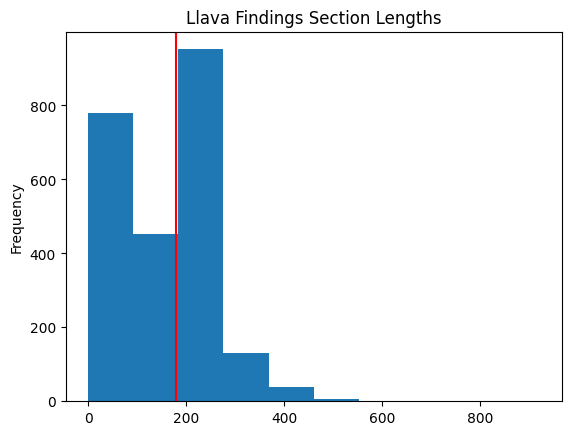

In [28]:
llava_findings_lengths[llava_findings_lengths < 1000].plot(kind='hist') # excluding the nonsensical outliers
plt.title('Llava Findings Section Lengths')
plt.axvline(np.median(llava_findings_lengths), color='red')
plt.savefig(os.path.join(image_save_path, 'llava-findings-section-lengths'));

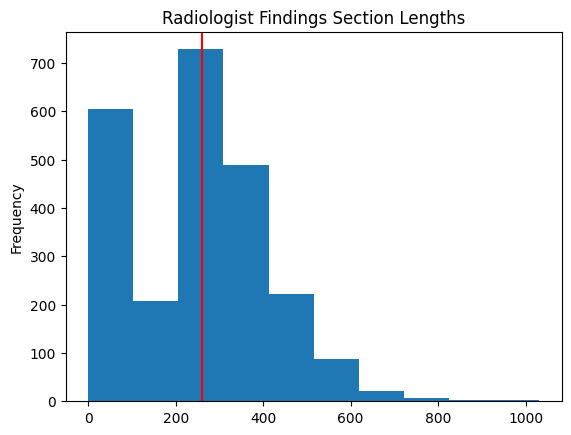

In [29]:
radiologist_findings_lengths.plot(kind='hist')
plt.title('Radiologist Findings Section Lengths')
plt.axvline(np.median(radiologist_findings_lengths), color='red')
plt.savefig(os.path.join(image_save_path, 'radiologist-findings-section-lengths'));

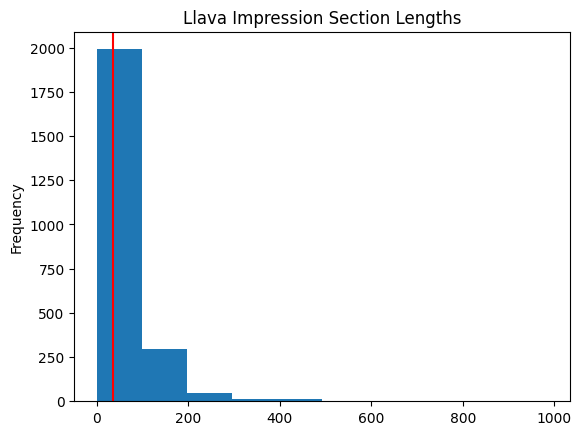

In [30]:
llava_impression_lengths[llava_impression_lengths < 1000].plot(kind='hist')
plt.title('Llava Impression Section Lengths')
plt.axvline(np.median(llava_impression_lengths), color='red')
plt.savefig(os.path.join(image_save_path, 'llava-impression-section-lengths'));

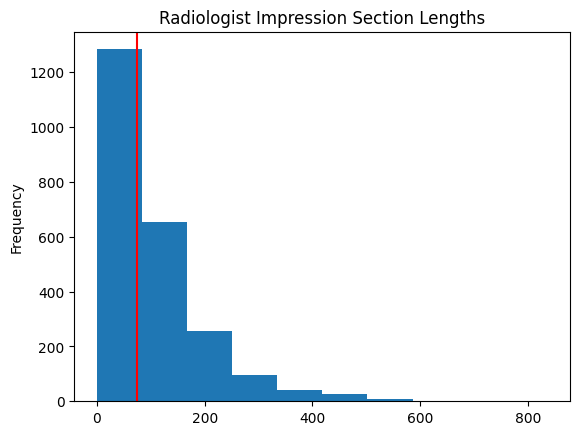

In [31]:
radiologist_impression_lengths.plot(kind='hist')
plt.title('Radiologist Impression Section Lengths')
plt.axvline(np.median(radiologist_impression_lengths), color='red')
plt.savefig(os.path.join(image_save_path, 'radiologist-impression-section-lengths'));


In [32]:
test_inference[['llava_impression']][llava_impression_lengths > 500]

,llava_impression
578,1.\nStable position left anterior chest wall s...
718,There is a new right-sided chest port with the...
934,There is increased interstitial pulmonary edem...
1308,There is a new right chest wall cardiac pacer ...
1772,1.\nStable position left anterior chest wall p...
1823,There is a new right-sided MediPort with tip p...
1899,There is a new right-sided chest port with the...
2031,There is a new right-sided PICC with the tip a...
2138,Interval placement of a right-sided PICC with ...


In [33]:
test_inference['llava_findings'][llava_impression_lengths > 500]

578             Unknown
718      See impression
934     See impression.
1308     See impression
1772            Unknown
1823     See impression
1899     See impression
2031     See impression
2138     See impression
Name: llava_findings, dtype: object

In [34]:
test_inference[['llava_findings', 'lf_len', 'li_len', 'rf_len', 'ri_len']][llava_findings_lengths > 500]['llava_findings'].iloc[0]

'There is a new right-sided MediPort with tip projecting over the right atrium. There is a new right-sided PICC with tip projected over the right atrium. There is a new right-sided chest port with tip projected over the right atrium. There is a new right-sided subclavian stent with tip projected over the right subclavian vein. There is a new right-sided subclavian stent with tip projected over the right subclavian vein.\nThere is a new right-sided chest port with tip projected over the right atrium. There is a new right-sided subclavian stent with tip projected over the right subclavian vein. There is a new right-sided subclavian stent with tip projected over the right subclavian vein.\nThere is a new right-sided chest port with tip projected over the right atrium. There is a new right-sided subclavian stent with tip projected over the right subclavian vein. There is a new right-sided subclavian stent with tip projected over the right subclavian vein.\nThere is a new right-sided chest 

In [35]:
test_inference[['llava_findings', 'llava_impression', 'radiologist_findings', 'radiologist_impression', 'similarity', 'lf_len', 'li_len', 'rf_len', 'ri_len', 'is_si_l', 'is_si_r']][llava_impression_lengths > 500]

,llava_findings,llava_impression,radiologist_findings,radiologist_impression,similarity,lf_len,li_len,rf_len,ri_len,is_si_l,is_si_r
578,Unknown,1.\nStable position left anterior chest wall s...,Unknown,1.\nNo acute osseous abnormality.\n2.\nNormal ...,0.791009,7,514,7,390,True,True
718,See impression,There is a new right-sided chest port with the...,See impression,Similar subsegmental atelectasis/scarring at t...,0.674165,14,736,14,162,True,True
934,See impression.,There is increased interstitial pulmonary edem...,See impression.,The cardiac silhouette is large but stable. Lu...,0.709863,15,3977,15,229,True,True
1308,See impression,There is a new right chest wall cardiac pacer ...,See impression,Low lung volumes with patchy atelectasis at bo...,0.281459,14,4277,14,60,True,True
1772,Unknown,1.\nStable position left anterior chest wall p...,*1.\nLines: Stable positioned left arm PICC li...,,0.593962,7,3899,423,0,True,False
1823,See impression,There is a new right-sided MediPort with tip p...,See impression,Clear lungs. No pneumothorax or pleural effusi...,0.492716,14,986,14,157,True,True
1899,See impression,There is a new right-sided chest port with the...,See impression,Somewhat low lung volumes with patchy atelecta...,0.369826,14,3918,14,260,True,True
2031,See impression,There is a new right-sided PICC with the tip a...,The lungs are clear without consolidation or p...,No acute cardiopulmonary process identified.,0.393168,14,3842,224,44,True,False
2138,See impression,Interval placement of a right-sided PICC with ...,Lines and Tubes: A left chest wall AICD is not...,Findings compatible with congestive heart fail...,0.792211,14,503,609,144,True,False


#### LLaVA Spewing Nonsense
There appears to be an issue where LLaVA just starts spewing out reptitive nonsense to certain prompts. Not sure why this happens though. But usually it responds with nothing (or unknown/see impression) in one of the sections while responding with all the nonsense in another section. 

In [36]:
test_inference

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity,is_si_l,is_si_r,lf_len,li_len,rf_len,ri_len
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.,0.765192,False,False,180,34,163,33
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...,0.886013,False,False,248,34,354,130
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.,0.849271,False,False,204,89,189,47
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...,0.883281,False,False,135,34,163,51
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.,0.904612,False,False,204,89,235,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,50669708,Udusay,"Ladd, William",Chest pain,See impression.,Normal cardiomediastinal silhouette. Clear lun...,FINDINGS:\nSee impression.\n\n\nIMPRESSION: No...,FINDINGS:\nSee impression.\n\nIMPRESSION: Norm...,See impression.,Normal heart size. Clear lungs and pleural spa...,0.789758,True,True,15,99,15,122
2365,52118594,Jojoli,"Weihe, Elizabeth","Shortness of breath, vomiting blood, hypoxia.",See impression,The cardiac silhouette is again enlarged. The ...,FINDINGS:\nSee impression\n\nIMPRESSION: The c...,FINDINGS:\nMediastinum: Enlarged cardiac silho...,Mediastinum: Enlarged cardiac silhouette is gr...,Evaluation is mildly limited given suboptimal ...,0.792548,True,False,14,361,445,75
2366,51962963,Fequera,"Friend, Christopher",Short of breath.,Heart size is normal. Pulmonary vasculature is...,No acute cardiopulmonary process.,FINDINGS:\nHeart size is normal. Pulmonary vas...,FINDINGS:\nHeart size normal. Pulmonary vascul...,Heart size normal. Pulmonary vasculature is no...,No acute findings.,0.834544,False,False,201,33,183,18
2367,50990038,Edaney,"Weihe, Elizabeth",CPR,Lines and Tubes: Endotracheal tube tip project...,Bibasal atelectasis.,FINDINGS:\nLines and Tubes: Endotracheal tube ...,FINDINGS: \nSingle portable view of the che...,Single portable view of the chest. The cardiac...,,0.681082,False,False,266,20,565,0


In [37]:
# 45 percent of see impressions match, basically (it's kinda meh)
test_inference[test_inference['is_si_l'] & test_inference['is_si_r']].shape[0] / test_inference[test_inference['is_si_l']  | test_inference['is_si_r']].shape[0]

0.45925925925925926

In [38]:
test_inference = test_inference[['id',
 'phonetic_id',
 'author',
 'clinical_history',
 'llava_findings',
 'llava_impression',
 'llava_report',
 'radiologist_report',
 'radiologist_findings',
 'radiologist_impression',
 'similarity']]

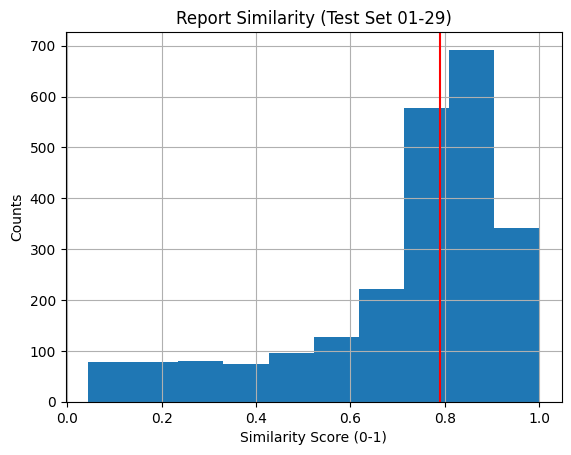

In [40]:
ax = test_inference['similarity'].hist()
plt.title('Report Similarity (Test Set 01-29)')
plt.axvline(test_inference['similarity'].median(), color='red')
plt.xlabel('Similarity Score (0-1)')
plt.ylabel('Counts')
plt.savefig(os.path.join(image_save_path, 'report-similarity-histogram'));

In [42]:
# ax = test_inference['sim_findings'].hist()
# plt.title('Findings Similarity (Test Set 01-29)')
# plt.xlabel('Similarity Score (0-1)')
# plt.ylabel('Counts');

In [27]:
# ax = test_inference['sim_impression'].hist(color='red')
# plt.title('Impressions Similarity (Test Set 01-29)')
# plt.xlabel('Similarity Score (0-1)')
# plt.ylabel('Counts');

In [28]:
# TODO tf-idf and find llm 

In [43]:
# def sim_score_by_author(author, kind='findings'):
#     '''creates a plot of that author's sim scores'''
#     filtered = test_inference[test_inference['author'] == author]
#     if kind == 'findings':
#         filtered['sim_findings'].plot(kind='hist')
#         plt.title(f'{author}--findings')
#         plt.xlabel('similarity scores')
#     else: 
#         filtered['sim_impression'].plot(kind='hist', color='red')
#         plt.title(f'{author}--impressions')
#         plt.xlabel('similarity scores')
def sim_score_by_author(author):
    '''creates a plot of that author's sim scores'''
    filtered = test_inference[test_inference['author'] == author]
    filtered['similarity'].plot(kind='hist')
    plt.title(f'{author}')
    plt.xlabel('similarity scores')
        

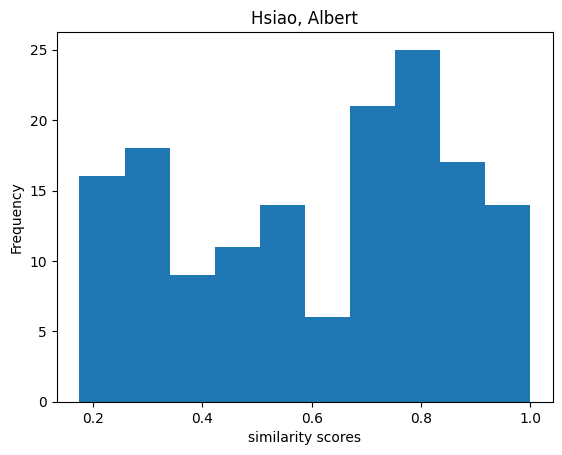

In [44]:
sim_score_by_author('Hsiao, Albert')

#### Analysis by Author

In [31]:
# TODO: explore the words in the data set
# common radiologists, what do they typically write their texts as 
# really only a small set of radiologists?

In [32]:
# assess LLM performance according to each author
# LLM to parse reports or find a NLP method of parsing

In [45]:
author_medians = dict()
top_authors = set(test_inference['author'].value_counts()[0:10].index)
for author in top_authors:
    author_medians[author] = np.median(test_inference[test_inference['author'] == author]['similarity'])

In [46]:
top_authors

{'Brouha, Sharon',
 'Delasotta, Lawrence',
 'Hahn, Lewis',
 'Horowitz, Michael',
 'Hsiao, Albert',
 'Jacobs, Kathleen',
 'Kligerman, Seth',
 'Ladd, William',
 'Weihe, Elizabeth',
 'Yen, Andrew'}

In [47]:
train_df['author'].value_counts()[0:10]

author
Yen, Andrew            2767
Brouha, Sharon         2305
Weihe, Elizabeth       1916
Horowitz, Michael      1757
Kligerman, Seth        1745
Ladd, William          1659
Jacobs, Kathleen       1644
Hsiao, Albert          1294
Hahn, Lewis             807
Delasotta, Lawrence     352
Name: count, dtype: int64

In [48]:
test_inference['author'].value_counts()[0:10]

author
Yen, Andrew            310
Brouha, Sharon         251
Kligerman, Seth        204
Weihe, Elizabeth       201
Horowitz, Michael      183
Jacobs, Kathleen       174
Ladd, William          174
Hsiao, Albert          151
Hahn, Lewis             99
Delasotta, Lawrence     36
Name: count, dtype: int64

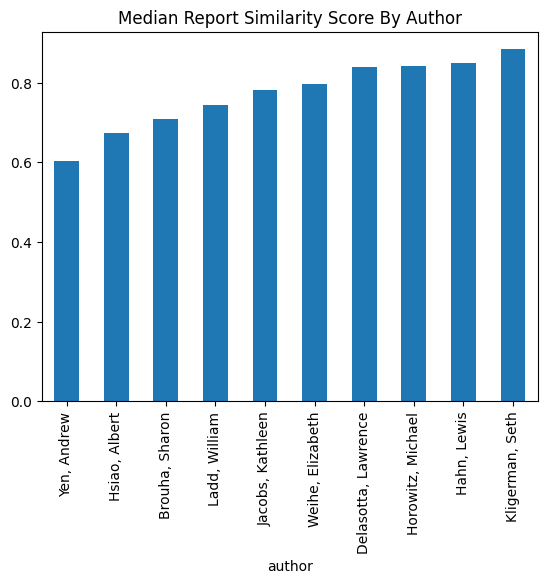

In [50]:
test_inference.groupby('author')['similarity'].median().loc[list(top_authors)].sort_values().plot(kind='bar')
plt.title('Median Report Similarity Score By Author')
plt.savefig(os.path.join(image_save_path, 'author-report-sims'));

### Calculate similarity scores by report subsection

In [51]:
llava_impression_embeddings, radiologist_impression_embeddings, test_inference['impression_similarity'] = get_sim_scores(test_inference['llava_impression'], test_inference['radiologist_impression'])
llava_findings_embeddings, radiologist_findings_embeddings, test_inference['findings_similarity'] = get_sim_scores(test_inference['llava_findings'], test_inference['radiologist_findings'])

/tmp/ipykernel_539781/3537431554.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llava_impression_embeddings, radiologist_impression_embeddings, test_inference['impression_similarity'] = get_sim_scores(test_inference['llava_impression'], test_inference['radiologist_impression'])
/tmp/ipykernel_539781/3537431554.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  llava_findings_embeddings, radiologist_findings_embeddings, test_inference['findings_similarity'] = get_sim_scores(test_inference['llava_findin

In [52]:
test_inference

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity,impression_similarity,findings_similarity
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.,0.765192,0.851804,0.548985
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...,0.886013,0.686182,0.886740
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.,0.849271,0.412907,0.814471
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...,0.883281,0.490818,0.910494
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.,0.904612,0.526602,0.909225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,50669708,Udusay,"Ladd, William",Chest pain,See impression.,Normal cardiomediastinal silhouette. Clear lun...,FINDINGS:\nSee impression.\n\n\nIMPRESSION: No...,FINDINGS:\nSee impression.\n\nIMPRESSION: Norm...,See impression.,Normal heart size. Clear lungs and pleural spa...,0.789758,0.726770,1.000000
2365,52118594,Jojoli,"Weihe, Elizabeth","Shortness of breath, vomiting blood, hypoxia.",See impression,The cardiac silhouette is again enlarged. The ...,FINDINGS:\nSee impression\n\nIMPRESSION: The c...,FINDINGS:\nMediastinum: Enlarged cardiac silho...,Mediastinum: Enlarged cardiac silhouette is gr...,Evaluation is mildly limited given suboptimal ...,0.792548,0.280400,0.072197
2366,51962963,Fequera,"Friend, Christopher",Short of breath.,Heart size is normal. Pulmonary vasculature is...,No acute cardiopulmonary process.,FINDINGS:\nHeart size is normal. Pulmonary vas...,FINDINGS:\nHeart size normal. Pulmonary vascul...,Heart size normal. Pulmonary vasculature is no...,No acute findings.,0.834544,0.613404,0.823044
2367,50990038,Edaney,"Weihe, Elizabeth",CPR,Lines and Tubes: Endotracheal tube tip project...,Bibasal atelectasis.,FINDINGS:\nLines and Tubes: Endotracheal tube ...,FINDINGS: \nSingle portable view of the che...,Single portable view of the chest. The cardiac...,,0.681082,0.066554,0.614705


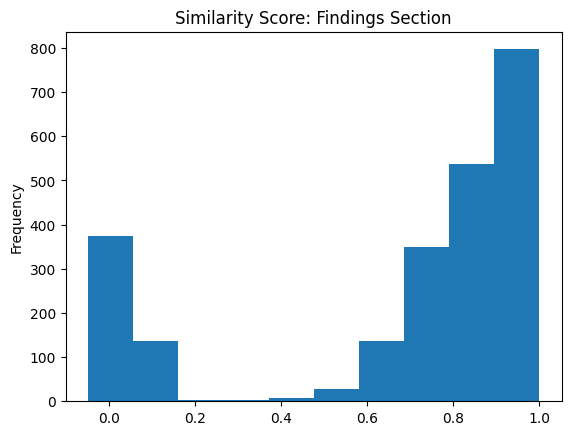

In [53]:
test_inference['findings_similarity'].plot(kind='hist')
plt.title('Similarity Score: Findings Section')
plt.savefig(os.path.join(image_save_path, 'findings-sim-histogram'));

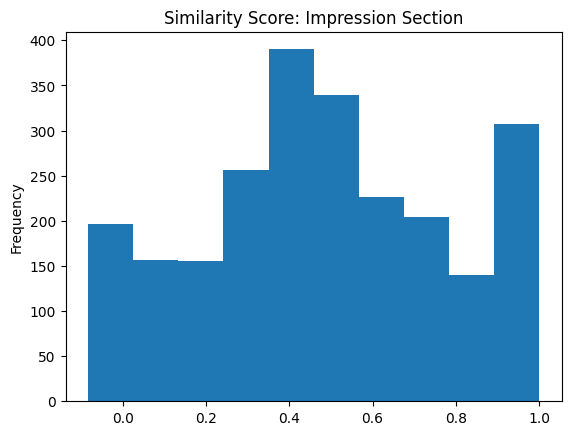

In [54]:
test_inference['impression_similarity'].plot(kind='hist')
plt.title('Similarity Score: Impression Section')
plt.savefig(os.path.join(image_save_path, 'impression-section-sim-hist'));

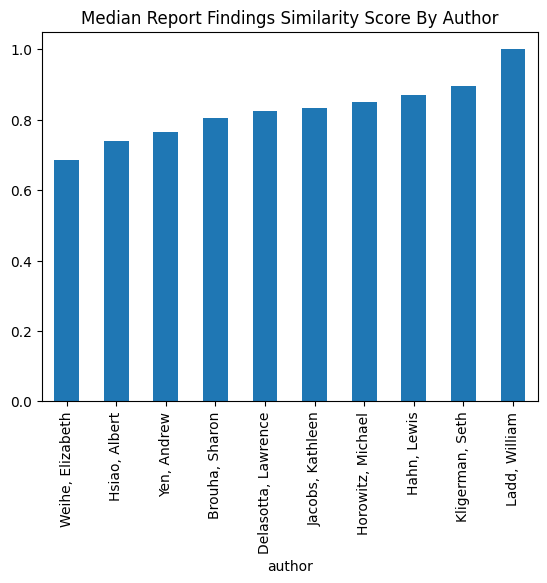

In [55]:
test_inference.groupby('author')['findings_similarity'].median().loc[list(top_authors)].sort_values().plot(kind='bar')
plt.title('Median Report Findings Similarity Score By Author')
plt.savefig(os.path.join(image_save_path, 'author-findings-similarity'));

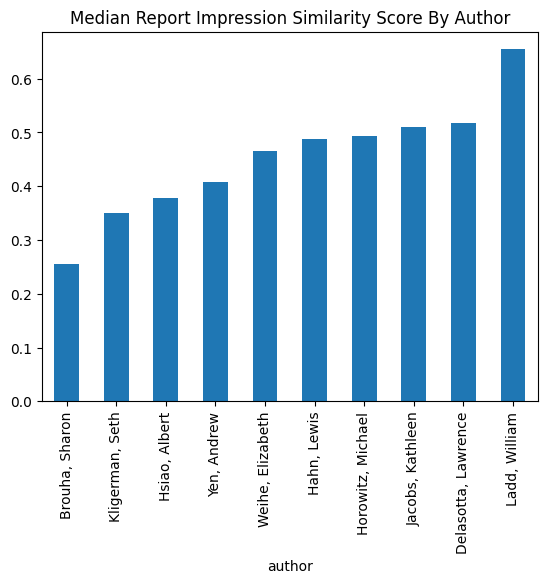

In [56]:
test_inference.groupby('author')['impression_similarity'].median().loc[list(top_authors)].sort_values().plot(kind='bar')
plt.title('Median Report Impression Similarity Score By Author')
plt.savefig(os.path.join(image_save_path, 'author-impression-similarity'));

#### Extract Performance on Specific Findings and Conditions

Maybe use tf idf? Language model? Some way to extract the key findings like is there edema T/F? Maybe look at the labels for the CheXpert or a labeled dataset and make label like stuff. 

Also find a chatbot that can perform language analysis on why the model does so poorly for certain authors.

In [44]:
test_inference.head()

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity,impression_similarity,findings_similarity
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.,0.765192,0.851804,0.548985
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...,0.886013,0.686182,0.886740
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.,0.849271,0.412907,0.814471
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...,0.883281,0.490818,0.910494
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.,0.904612,0.526602,0.909225


In [45]:
from transformers import pipeline
classifier = pipeline("zero-shot-classification",
                      model="valhalla/distilbart-mnli-12-3", multilabel=True)
# "facebook/bart-large-mnli"
# hopefully distilbart can work faster than facebook 
# bart without losing too much accuracy 

In [46]:
sequence_to_classify = test_inference['radiologist_report'].iloc[93]
print(sequence_to_classify)

FINDINGS:
See IMPRESSION.


IMPRESSION: Devices: Interval extubation. Visualized portions of other support lines and tubes are stable in position.


In [47]:
candidate_labels = [
'No Abnormality',
'Aortic enlargement',
'Atelectasis',
'Calcification',
'Cardiomegaly',
'Consolidation',
'ILD',
'Infiltration',
'Lung Opacity',
'Nodule/Mass',
'Other lesion',
'Pleural effusion',
'Pleural thickening',
'Pneumothorax',
'Pulmonary fibrosis']


In [48]:
# test_inference.to_csv('./test_inference.csv')

In [49]:
# sequences = list(test_inference['radiologist_impression'].iloc[:50])

# classifier(sequences, candidate_labels)

In [50]:
# should take one hour and 12 minutes for distilbart

In [1]:
98 / 2

49.0

In [3]:
75 * 49 / 60 # oof, running on ENTIRE DATASET takes a LONG TIME
# is there a method to speed this up?
# some cuda trick?

61.25

In [4]:
61.25 / 24 # so bascially the tmux window should finish operating by Friday EOD at the latest 

2.5520833333333335

In [51]:
# BART: 2 mins 56 seconds
# DistilBART: 1 min 40 seconds
sequences = list(test_inference['radiologist_report'].iloc[:50])

classifier(sequences, candidate_labels)

[{'sequence': 'FINDINGS:\nLow lung volumes with bibasal atelectasis. No focal consolidation. No pleural effusion. No pneumothorax. Stable cardiomediastinal silhouette and regional skeleton.\n\n\nIMPRESSION: No acute cardiopulmonary disease.',
  'labels': ['No Abnormality',
   'Atelectasis',
   'Pneumothorax',
   'Cardiomegaly',
   'Consolidation',
   'Lung Opacity',
   'Pleural effusion',
   'Pulmonary fibrosis',
   'Other lesion',
   'Pleural thickening',
   'Nodule/Mass',
   'Infiltration',
   'Calcification',
   'ILD',
   'Aortic enlargement'],
  'scores': [0.1213206946849823,
   0.10611411184072495,
   0.09897962957620621,
   0.09618184715509415,
   0.09064467996358871,
   0.08911418914794922,
   0.07670453190803528,
   0.05508541315793991,
   0.04648102447390556,
   0.0436897799372673,
   0.04336782172322273,
   0.04291538894176483,
   0.038290467113256454,
   0.0336628295481205,
   0.017447493970394135]},
 {'sequence': 'FINDINGS:\nModerate lung expansion. Septal thickening and th

In [52]:
def classify_reports(reports, candidate_labels):
    results = classifier(reports, candidate_labels)
    structured_results = []
    for result in results:
        scores_dict = {label: score for label, score in zip(result['labels'], result['scores'])}
        scores_dict['report'] = result['sequence']
        structured_results.append(scores_dict)
    return structured_results

# Load your data (example, replace with actual DataFrame loading if needed)
# test_inference = pd.read_csv('your_data_file.csv')

# Extract the first 50 reports for classification
reports = list(test_inference['radiologist_report'].iloc[:10])

# Classify and structure the report scores
structured_results = classify_reports(reports, candidate_labels)

# Create a DataFrame from the structured results
results_df = pd.DataFrame(structured_results)

results_df['id'] = test_inference['id']

# Ensure the 'report' column is the first column
columns = ['report'] + [col for col in results_df.columns if col != 'report']
results_df = results_df[columns]

# Save the results to a CSV file
results_df.to_csv('classified_reports.csv', index=False)

print("Classification completed and saved to classified_reports.csv")


Classification completed and saved to classified_reports.csv


#### Facebook BART run time 
`(2369 * (130 / 50)) / 60 = 102.65666666666668` minutes to run on entire evaluation dataset

In [53]:
# POSSIBLE MODELS LISTED DOWN HERE (DON"T DELETE THIS)
# CAN look into BART models too
#generator = pipeline(model="microsoft/biogpt") #microsoft/biogpt stanford-crfm/BioMedLM Mbilal755/Radiology_Bart

#### Using ROUGE to evaluate the model

In [54]:
import evaluate

In [55]:
rouge = evaluate.load('rouge')

In [56]:
i = 0
rr = test_inference.iloc[i]['radiologist_report']
lr = test_inference.iloc[i]['llava_report']

In [57]:
predictions = ['FINDINGS:\nLow lung volumes with bibasal atelectasis. No focal consolidation. No pleural effusion. No pneumothorax. Stable cardiomediastinal silhouette and regional skeleton.\n\n\nIMPRESSION: No acute cardiopulmonary disease.']
references = ['FINDINGS:\nLines and Tubes: None\nMediastinum: The cardiomediastinal silhouette is unchanged.\nLungs: The lungs are clear.\nPleura: No pneumothorax or effusion.\nBones and soft tissues: Unchanged\n\nIMPRESSION: No acute cardiopulmonary findings.']

rouge.compute(predictions=predictions, references=references)

{'rouge1': 0.3859649122807018,
 'rouge2': 0.1818181818181818,
 'rougeL': 0.2807017543859649,
 'rougeLsum': 0.3508771929824561}

In [58]:
predictions = test_inference['llava_report'].iloc[0:10]
references = test_inference['radiologist_report'].iloc[0:10]

In [59]:
rouge.compute(predictions=predictions, references=references)

{'rouge1': 0.44327603892142664,
 'rouge2': 0.27951016739592727,
 'rougeL': 0.4057921837563252,
 'rougeLsum': 0.4235182041242248}

In [60]:
test_inference[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']] =test_inference.apply(lambda x: rouge.compute(predictions=[x['llava_report']], references=[x['radiologist_report']]), 
                        axis=1, result_type='expand')

/tmp/ipykernel_349238/752987971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inference[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']] =test_inference.apply(lambda x: rouge.compute(predictions=[x['llava_report']], references=[x['radiologist_report']]),
/tmp/ipykernel_349238/752987971.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_inference[['rouge1', 'rouge2', 'rougeL', 'rougeLsum']] =test_inference.apply(lambda x: rouge.compute(predictions=[x['llava_report']], references=[x['radiologist_

In [61]:
test_inference

,id,phonetic_id,author,clinical_history,llava_findings,llava_impression,llava_report,radiologist_report,radiologist_findings,radiologist_impression,similarity,impression_similarity,findings_similarity,rouge1,rouge2,rougeL,rougeLsum
0,52925711,Najitir,"Liau, Joy",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,No acute cardiopulmonary findings.,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLow lung volumes with bibasal atele...,Low lung volumes with bibasal atelectasis. No ...,No acute cardiopulmonary disease.,0.765192,0.851804,0.548985,0.385965,0.181818,0.280702,0.350877
1,52227435,Lastrolu,"Jacobs, Kathleen",Back pain and history of heart failure\nCOMPAR...,Lungs are well expanded. Cephalization of pulm...,Mild interstitial pulmonary edema.,FINDINGS:\nLungs are well expanded. Cephalizat...,FINDINGS:\nModerate lung expansion. Septal thi...,Moderate lung expansion. Septal thickening and...,Mild pulmonary edema and small left pleural ef...,0.886013,0.686182,0.886740,0.411765,0.180000,0.352941,0.352941
2,52668517,Kuluegan,"Hahn, Lewis",Wheezing and dyspnea on exertion,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: Cardiac si...,Mild pulmonary edema and moderate cardiomegaly.,0.849271,0.412907,0.814471,0.533333,0.383562,0.506667,0.533333
3,50394671,Phinesdreek,"Hsiao, Albert",Shortness of breath,Unremarkable cardiomediastinal silhouette.\nNo...,No acute cardiopulmonary findings.,FINDINGS:\nUnremarkable cardiomediastinal silh...,FINDINGS:\nStable enlarged cardiomediastinal s...,Stable enlarged cardiomediastinal silhouette.\...,Cardiomegaly and mild interstitial pulmonary e...,0.883281,0.490818,0.910494,0.652174,0.545455,0.652174,0.652174
4,52789390,Nenieri,"Hahn, Lewis",Chest pain,Lines and Tubes: None\nMediastinum: The cardio...,Bronchial wall thickening which can be seen wi...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,FINDINGS:\nLines and Tubes: None\nMediastinum:...,Lines and Tubes: None\nMediastinum: The cardio...,Mild pulmonary edema.,0.904612,0.526602,0.909225,0.649351,0.586667,0.649351,0.649351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2364,50669708,Udusay,"Ladd, William",Chest pain,See impression.,Normal cardiomediastinal silhouette. Clear lun...,FINDINGS:\nSee impression.\n\n\nIMPRESSION: No...,FINDINGS:\nSee impression.\n\nIMPRESSION: Norm...,See impression.,Normal heart size. Clear lungs and pleural spa...,0.789758,0.726770,1.000000,0.390244,0.256410,0.390244,0.390244
2365,52118594,Jojoli,"Weihe, Elizabeth","Shortness of breath, vomiting blood, hypoxia.",See impression,The cardiac silhouette is again enlarged. The ...,FINDINGS:\nSee impression\n\nIMPRESSION: The c...,FINDINGS:\nMediastinum: Enlarged cardiac silho...,Mediastinum: Enlarged cardiac silhouette is gr...,Evaluation is mildly limited given suboptimal ...,0.792548,0.280400,0.072197,0.311475,0.066667,0.229508,0.278689
2366,51962963,Fequera,"Friend, Christopher",Short of breath.,Heart size is normal. Pulmonary vasculature is...,No acute cardiopulmonary process.,FINDINGS:\nHeart size is normal. Pulmonary vas...,FINDINGS:\nHeart size normal. Pulmonary vascul...,Heart size normal. Pulmonary vasculature is no...,No acute findings.,0.834544,0.613404,0.823044,0.492308,0.349206,0.492308,0.492308
2367,50990038,Edaney,"Weihe, Elizabeth",CPR,Lines and Tubes: Endotracheal tube tip project...,Bibasal atelectasis.,FINDINGS:\nLines and Tubes: Endotracheal tube ...,FINDINGS: \nSingle portable view of the che...,Single portable view of the chest. The cardiac...,,0.681082,0.066554,0.614705,0.246154,0.046875,0.169231,0.230769


### Read in BART Label Data Frames

In [62]:
radiologist_report_labels = pd.read_csv('./radiologist_classified_reports.csv')
llava_report_lavels = pd.read_csv('./llava_classified_reports.csv')

### Plot ROUGE Scores 

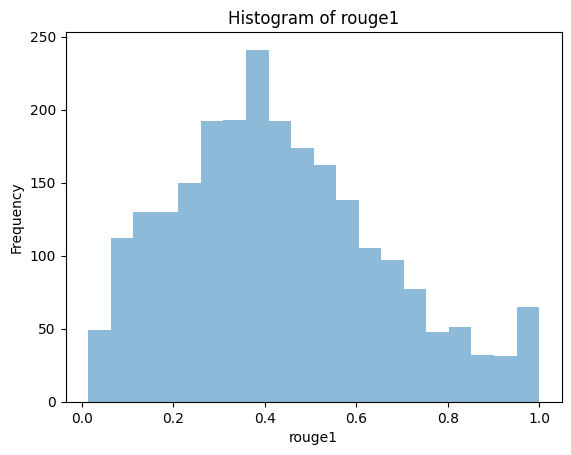

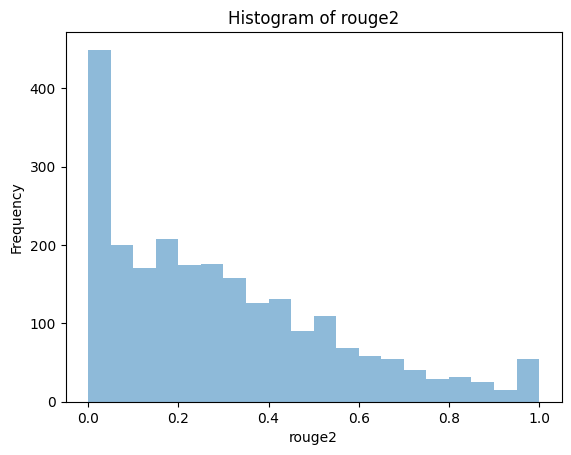

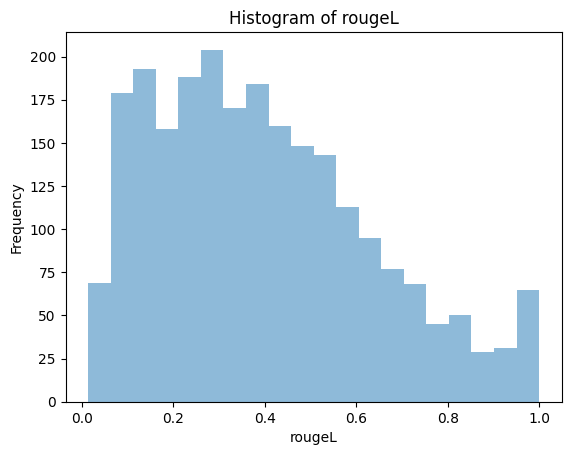

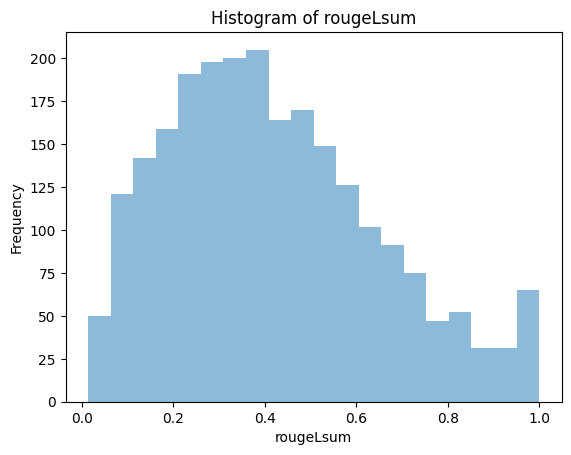

In [63]:
columns = ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']
for col in columns:
    test_inference[col].plot.hist(alpha=0.5, bins=20, title=f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### Section for findings and ideas summary after each work session
What have you done in each work session? Where is this leading you? 

2/8 345-545 (2 hours):
Researched different models that we can used for classification. Seems like BART models may work. I am not too sure how different they are to BERT. Need to do some more research on that. The Facebook zero shot has some promise, but could look into some more fine tuned models on Hugging Face for radiologist reports or load in a Langauge Model that can be prompted to do so. What are some candidate labels that you can use to better encompass the data? Do some research on this as well.

2/8 6-
BART: Bidirectional Auto Regressive Transformers
BERT: Bidirectional Encoder Representations from Transformers (a bidirectional model)
GPT: Generative Pretrained Transformer (Autoregressive)

BART combines the bidirectional aspect or BERT with the autoregressive aspect of GPT. 

Creates context using an encoder, then, using the encoder, generates the next most probable text similar to chat gpt would. Does this really improve the perfomance? Or would just a plain old GPT-like model work just as well?

Learned about Natural Language Inference Models (NLI): These are given a 1. premise and 2. hypothesis and are asked to detrmine whether the hypothesis is true. So BART is an NLI right? I guess we should learn more about how the Facebook model was trained (you know need to understand your sources and back up why you chose them to your stakeholders so you can reevaluate) to understand it I think it is an NLI model.


How to improve zero shot: 
* add a label for "no findings" or something like "N/A" since sometimes the findings are in another section.
* we can also tailor the candidate labels to the column it is being evaluated on. 
* I think one thing we can do is perhaps compare the candidate label scores between one model and the other. I think we first need to determine that the model is capable of understanding and parsing the labels well, find the appropriate labels for our dataset, then do the computation and somehow compare the performance.
* Can try a few models and compare results (BART, BERT, and a GPT-like model) to determine which is best at evaluation. 
* Do these metrics make sense? Can we show the common person these metrics to show that we made an improvement. 

NEED TO CREATE SCRIPT THAT CAN OUTPUT PERFORMANCE METRICS BY THE END OF THIS WEEKEND. TREAT THIS WEEKEND AS A HACKATHAON TO GET THIS PROJECT DONE.

IDEA: use the zero shot labels to create labels, scores pairs for each radiologist and llava report pair and compare the label scores between them as a metric!

2/11 - 
[AI in radiology article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8017417/)

Started writing report for the capstone, started thinking about the bigger picture. Need to learn about the shortcomings of past AI models in medicine. How is the high false positive rate addressed in our model? How do we adress the long tail problem? Do we understand the process of what a radiologist perceives to make their decision? Or are we oversimplifying this in the model?

Long tail issue: maybe we need to a way for the AI to express its certainty level. What if LLAVA can give a diagnosis with a level of how confident it is in its diagnosis? This would be useful for helping radiologists because they can pay more attention to scores with low confidence if the AI is unsure of a diagnosis (and if we know that this score is correlated with prediction accuracy.)

Do we need basic Language Model evaluation metrics? Perplexity?

Instead of saving images to a pdf, save them to a folder after the eval script is run, then make a Markdown file that loads in the images with links to the saved images. That way we can use these higher quality images in report instead of basic screenshots. 


need to work on 1. new prompts not trained on 2. improved for particular author